In [1]:
import sys
!{sys.executable} -m pip install chess

import os.path
import itertools
import numpy as np
import scipy.ndimage as ndi
from skimage import io, color, filters, feature, segmentation, measure, draw, exposure, transform
from sklearn import cluster # scikit-learn: a machine learning library
import matplotlib as mpl
import matplotlib.pylab as plt
import cv2

import math
import chess


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [2]:
plt.gray();
mpl.rcParams['figure.figsize'] = (10,10)

<Figure size 432x288 with 0 Axes>

In [3]:
if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git

Already up to date.


In [4]:
# FEN starts from rank 8 and ends at rank 1
# A number in FEN represents number of empty spaces

RANK_DELIMITER = '/'

WHITE_KING = 'K'
WHITE_QUEEN = 'Q'
WHITE_BISHOP = 'B'
WHITE_KNIGHT = 'N'
WHITE_ROOK = 'R'
WHITE_PAWN = 'P'

BLACK_KING = 'k'
BLACK_QUEEN = 'q'
BLACK_BISHOP = 'b'
BLACK_KNIGHT = 'n'
BLACK_ROOK = 'r'
BLACK_PAWN = 'p'

WHITES_TURN = 'w'
BLACKS_TURN = 'b'

WHITE_KINGSIDE_CASTLES = 'K'
WHITE_QUEENSIDE_CASTLES = 'Q'
BLACK_KINGSIDE_CASTLES = 'k'
BLACK_QUEENSIDE_CASTLES = 'q'
NO_CASTLES = '-'

# If there is an en passant then target square is recorded
NO_ENPASSANT = '-'

# The number of halfmoves since the last capture or pawn advance, used for the fifty-move rule
DEFAULT_HALF_MOVES = 0

# The number of the full move. It starts at 1, and is incremented after Black's move.
DEFAULT_HALF_MOVES = 1


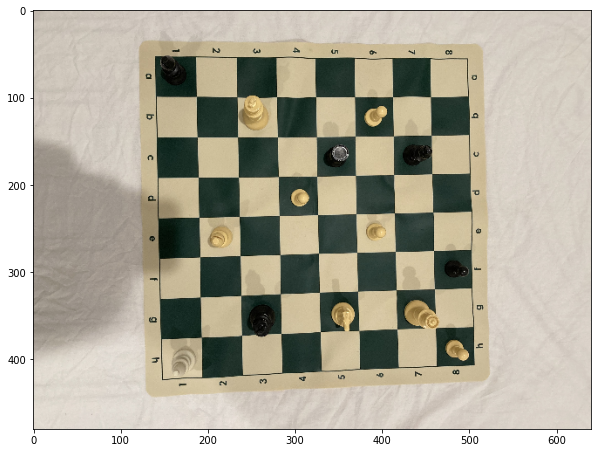

In [5]:
VIDEO_SHAPE = (640, 480) # shape of the image the video gives
BOARD_CUTOUT_SIZE = (480, 480) # shape that the cutout of the board should be resized to

im_board = io.imread('chess_board_images/board_pieces_1.jpg')
im_board = cv2.resize(im_board, VIDEO_SHAPE)

plt.imshow(im_board)

In [6]:
EDGE_DETECTION_THRESHOLD = 0.05
GAUSSIAN_BLUR_SIGMA = 0.7

In [7]:

def process_chessboard_im(im):
    '''
    This function is designed to do a set of basic filters and thresholds in order to
    prepare a chessboard image for Hough Line Detection.

    Arguments:
        im the image to process

    Returns:
        the processed image
    '''
    gray = color.rgb2gray(im) # convert to grayscale
    blurred = ndi.gaussian_filter(gray, GAUSSIAN_BLUR_SIGMA) # blur
    edges = filters.sobel(blurred) # detect edges
    thresh = edges > EDGE_DETECTION_THRESHOLD # threshold

    return thresh

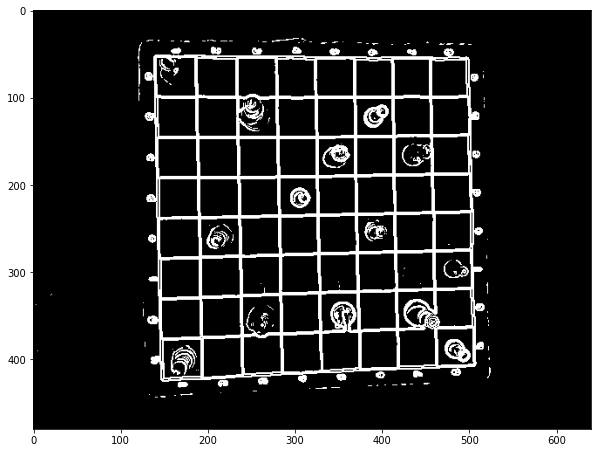

In [8]:
im_processed = process_chessboard_im(im_board)
plt.imshow(im_processed)

In [9]:
def angle_to_slope(angle):
    '''
    Converts an angle to a slope m in the form y = mx + b.

    Arguments:
        angle the angle in radians to convert to a slope

    Returns:
        the slope value
    '''
    return np.tan(angle + (np.pi/2))

def angles_dists_to_points(angles, dists):
    '''
    Returns x and y points for each line

    Arguments:
        angles a list of the lines' angles
        dists a list of the lines' distances

    Returns:
        a list of x coordinates and a list of y coordinates of the points
    '''
    x_coords = dists * np.cos(angles)
    y_coords = dists * np.sin(angles)

    return x_coords, y_coords

def angles_dists_to_points_slopes(angles, dists):
    '''
    Returns x and y points, as well as the slopes, for each line

    Arguments:
        angles a list of the lines' angles
        dists a list of the lines' distances

    Returns:
        a list of x coordinates, a list of y coordinates, and a list of slopes for each line
    '''
    x_coords = dists * np.cos(angles)
    y_coords = dists * np.sin(angles)
    
    slopes = [angle_to_slope(a) for a in angles]

    return x_coords, y_coords, slopes

In [10]:
HOUGH_LINES_DISPLAY_WIDTH = 4

In [11]:
def plot_lines_hough(im, angles, dists, points=[], line_color='red', point_color='blue'):
    '''
    Plots an image (im) and then draws the lines as given by the angles (in radians)
    and distances from (0,0).
    Optionally draws a list of points given by (points).

    Arguments:
        im the image to plot over
        angles a list of the lines' angles (radians)
        dists a list of the lines' distances
        points a list of points as (x, y) tuples to plot
        line_color the color to plot the lines in
        plot_color the color to plot the points in
    '''
    x_coords, y_coords = angles_dists_to_points(angles, dists)

    plt.imshow(im)

    # Force the limits on the axes
    h, w = im.shape
    plt.xlim((0, w))
    plt.ylim((h, 0))

    # Plot the lines
    for x, y, angle in zip(x_coords, y_coords, angles):
        # plt.plot(x, y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
        plt.axline((x, y), slope=angle_to_slope(angle), color=line_color, linewidth=HOUGH_LINES_DISPLAY_WIDTH)

    # Plot the points
    for x, y in points:
        plt.plot(x, y, color=point_color, marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [12]:
def hough_lines(im):
    '''
    Basic Hough line transform.

    Arguments:
        im the image to get the lines for

    Returns:
        a list of angles and a list of distances of the most prominent lines in the image.
    '''
    hspace, angles, dists = transform.hough_line(im)
    peak_vals, angles, dists = transform.hough_line_peaks(hspace, angles, dists)
    return angles, dists

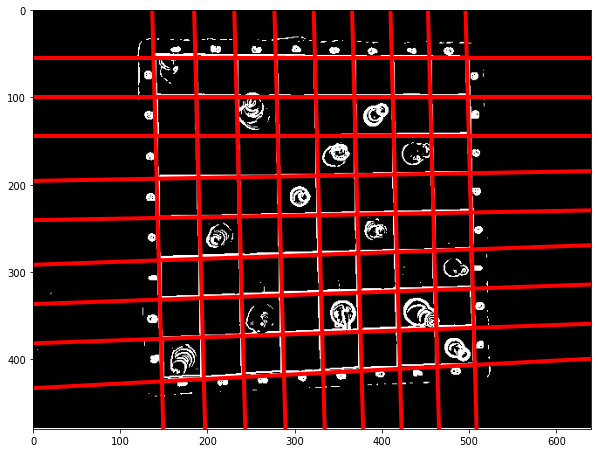

In [13]:
angles, dists = hough_lines(im_processed)
plot_lines_hough(im_processed, angles, dists)

In [14]:
def index_top_two_max(arr):
    '''
    Finds the indexes of the top two largest elements.

    Arguments:
        arr the list to find the largest elements in.

    Returns:
        a list that contains the top two indexes.
    '''
    assert len(arr) >= 2
    indices, _ = zip(*sorted(enumerate(arr), key=lambda x: x[1]))
    return indices[-2:]

def swap_lesser(a, b):
    '''
    Returns the smallest element first.

    Arguments:
        a the first element
        b the first element
    
    Returns:
        both elements in smallest order
    '''
    if (a < b):
        return a, b
    else:
        return b, a

def smallest_difference_between_angles(a, b):
    '''
    finds the minimum distance between the points of angles.

    Arguments:
        a the first angle (radians)
        b the second angle (radians)
    
    Returns:
        the smallest difference between the angles
    '''
    a, b = swap_lesser(a, b)

    bounds = math.pi / 2
    return min(
        abs(a - b),
        abs(-bounds - a) + abs(bounds - b)
    )

def get_angle_gradients(lines):
    '''
    Gets the gradients of the angles of the lines.

    Arguments:
        lines a list of (angle, dist) tuples that are sorted by angle

    Returns:
        a list of gradients for the angles
    '''
    angle_gradients = []

    for i in range(len(lines)):
        angle_1 = lines[i][0]
        angle_2 = lines[(i+1) % len(lines)][0]
        
        angle_gradients.append(
            smallest_difference_between_angles(angle_1, angle_2)
        )

    return angle_gradients

def split_lines(angles, dists):
    '''
    Finds the peaks of the gradients of the angles of the lines in order to separate it into two clusters.

    Arguments:
        angles a list of the lines' angles (radians)
        dists a list of the lines' distances

    Returns:
        a tuple of the angles and distances of the first cluster and then another for the second cluster.
    '''
    assert len(angles) == len(dists)

    if len(angles) < 2:
        return (angles, dists), ([], [])

    # Sort lines
    lines = zip(angles, dists)
    lines = sorted(lines, key=lambda l: l[0])

    # get gradient of angles
    angle_gradients = get_angle_gradients(lines)

    # get the indices of the top two peaks in the gradient
    i1_max, i2_max = index_top_two_max(angle_gradients)
    assert i1_max != i2_max
    i1_max, i2_max = swap_lesser(i1_max, i2_max)

    # extract clusters from peaks
    lines_1 = lines[i1_max+1:i2_max+1]
    lines_2 = lines[i2_max+1:] + lines[:i1_max+1]

    return zip(zip(*lines_1), zip(*lines_2))

In [15]:
def normalize_angle(angle):
    '''
    Puts an angle in the range of -180 to 180 degrees.

    Arguments:
        angle the angle (radians) to normalize
    
    Returns:
        the normalized angle
    '''
    two_pi = 2 * math.pi
    angle %= two_pi

    angle = (angle + two_pi) % two_pi

    if (angle > math.pi):  
        angle -= 2 * math.pi
    
    return angle

def is_angle_in_range(angle, r):
    '''
    Checks if an angle is within a range.

    Arguments:
        angle the angle (radians) to check
        r the range which is a tuple (start, end) where start and end are between -1 and 1.
    
    Returns:
        whether or not the angle is in the range.
    '''
    return (r[0] * (math.pi / 2)) <= angle <= (r[1] * (math.pi / 2))

def get_lines_range(angles, dists, ranges):
    '''
    Finds the lines that match at least one of the ranges.

    Arguments:
        angles a list of the lines' angles (radians).
        dists a list of the lines' distances.
        ranges a list of the ranges to check.

    Returns:
        a list of angles and a list of dists of the filtered lines
    '''
    assert len(angles) == len(dists)

    lines = zip(angles, dists)

    lines = [l for l in lines if any([is_angle_in_range(l[0], r) for r in ranges])]
    return zip(*lines) if lines else ([], [])

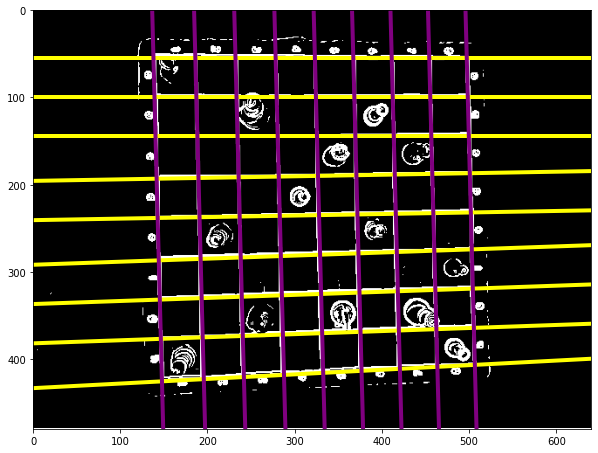

In [16]:
normalized_angles = [normalize_angle(a) for a in angles]

h_angles, h_dists = get_lines_range(normalized_angles, dists, [(-1, -6/8), (6/8, 1)])
v_angles, v_dists = get_lines_range(normalized_angles, dists, [(-2/8, 2/8)])

plot_lines_hough(im_processed, h_angles, h_dists, line_color='yellow')
plot_lines_hough(im_processed, v_angles, v_dists, line_color='purple')

In [17]:
def wrap_slice(arr, i_cur, i_next):
    '''
    Slices a list but wraps the slice if i_cur is greater than i_next.

    Arguments:
        arr the list to slice
        i_cur the start index
        i_next the end index

    Returns:
        the wrapped slice
    '''
    i_cur += 1
    i_next += 1
    if i_cur <= i_next:
        return arr[i_cur:i_next]
    else:
        return arr[i_cur:] + arr[:i_next]

In [18]:
'''
Filters lines that are not close together.

Arguments:
    angles a list of the lines' angles (radians)
    dists a list of the lines' distances
    cluster_range how close the angles should be together

Returns:
    the pruned lines
'''
def prune_lines_by_angle(angles, dists, cluster_range=0.2):
    assert len(angles) == len(dists)

    if len(angles) == 0:
        return [], []

    cluster_range *= 2 * math.pi

    # Sort lines
    lines = zip(angles, dists)
    lines = sorted(lines, key=lambda l: l[0])

    # get gradient of angles
    angle_gradients = get_angle_gradients(lines)
    
    gradient_peak_indices = []
    for i, gradient in enumerate(angle_gradients):
        if gradient > cluster_range:
            gradient_peak_indices.append(i)

    if len(gradient_peak_indices) < 2:
        return zip(*lines)

    line_clusters = []
    for i, peak_index in enumerate(gradient_peak_indices):
        peak_index_next = gradient_peak_indices[(i+1) % len(gradient_peak_indices)]
        line_clusters.append(wrap_slice(lines, peak_index, peak_index_next))

    last_cluster = sorted(line_clusters, key=lambda c: len(c))[-1]

    return zip(*last_cluster)

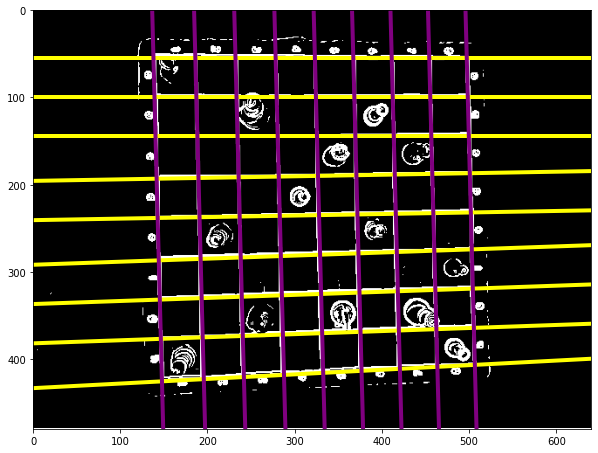

In [19]:
h_angles_2, h_dists_2 = prune_lines_by_angle(h_angles, h_dists)
v_angles_2, v_dists_2 = prune_lines_by_angle(v_angles, v_dists)

plot_lines_hough(im_processed, h_angles_2, h_dists_2, line_color='yellow')
plot_lines_hough(im_processed, v_angles_2, v_dists_2, line_color='purple')

In [20]:
def find_y_intercept(x, y, slope):
    '''
    Finds the y intercept.

    Arguments:
        x the x value
        y the y value
        slope the slope of the line
    
    Returns:
        the y intercept
    '''
    return y - (slope * x)

In [21]:
def solve_linear_equation(m1, b1, m2, b2):
    '''
    Finds the x and y values that solve the linear equation

    Arguments:
        m1 the slope of the first line
        b1 the y-intercept of the first line
        m2 the slope of the second line
        b2 the y-intercept of the second line
    
    Returns:
        a tuple (x, y) that is the solve point for the equation
    '''
    a = (m1 - m2)
    x = 0 if a == 0 else (b2 - b1) / a
    y = (m1 * x) + b1
    return x, y

In [22]:
def find_intersections(angles_1, dists_1, angles_2, dists_2):
    '''
    Finds the intersections between the two groups of lines.

    Arguments:
        angles_1 the first lines' angles (radians)
        dists_1 the first lines' distances
        angles_2 the second lines' angles (radians)
        dists_2 the second lines' distances
    
    Returns:
        a list of the intersections found where each intersection is a tuple (x, y)
    '''
    assert len(angles_1) == len(dists_1)
    assert len(angles_2) == len(dists_2)

    x_coords_1, y_coords_1, slopes_1 = angles_dists_to_points_slopes(angles_1, dists_1)
    x_coords_2, y_coords_2, slopes_2 = angles_dists_to_points_slopes(angles_2, dists_2)

    intercepts_1 = [find_y_intercept(x, y, s) for x, y, s in zip(x_coords_1, y_coords_1, slopes_1)]
    intercepts_2 = [find_y_intercept(x, y, s) for x, y, s in zip(x_coords_2, y_coords_2, slopes_2)]

    intersections = []

    for m1, b1 in zip(slopes_1, intercepts_1):
        for m2, b2 in zip(slopes_2, intercepts_2):
            intersections.append(solve_linear_equation(m1, b1, m2, b2))

    return intersections

def find_intersections_2(angles_1, dists_1, angles_2, x_coords_2, y_coords_2):
    '''
    Finds the intersections between the two groups of lines.

    Arguments:
        angles_1 the first lines' angles (radians)
        dists_1 the first lines' distances
        angles_2 the second lines' angles (radians)
        x_coords_2 the x coordinates for the second lines
        y_coords_2 the y coordinates for the second lines
    
    Returns:
        a list of the intersections found where each intersection is a tuple (x, y)
    '''
    assert len(angles_1) == len(dists_1)
    assert len(angles_2) == len(x_coords_2) == len(y_coords_2)

    x_coords_1, y_coords_1, slopes_1 = angles_dists_to_points_slopes(angles_1, dists_1)
    slopes_2 = [angle_to_slope(a) for a in angles_2]

    intercepts_1 = [find_y_intercept(x, y, s) for x, y, s in zip(x_coords_1, y_coords_1, slopes_1)]
    intercepts_2 = [find_y_intercept(x, y, s) for x, y, s in zip(x_coords_2, y_coords_2, slopes_2)]

    intersections = []

    for m1, b1 in zip(slopes_1, intercepts_1):
        for m2, b2 in zip(slopes_2, intercepts_2):
            intersections.append(solve_linear_equation(m1, b1, m2, b2))

    return intersections

In [23]:
def sort_lines_by_points(angles, dists, points, horizontal=True):
    '''
    Sorts the lines in horizontal or vertical order.

    Arguments:
        angles a list of the lines' angles (radians)
        dists a list of the lines' distances
        points a list of the intersections with the x or y axis
        horizontal whether to check for horizontal or vertical order

    Returns:
        the lines sorted
    '''
    assert len(angles) == len(dists) == len(points)

    if len(angles) == 0:
        return ([], [], [])

    xy_index = 1 if horizontal else 0

    lines = zip(angles, dists, points)
    lines = sorted(lines, key=lambda l: l[2][xy_index])

    return zip(*lines)

In [24]:
h, w = im_processed.shape

h_points = find_intersections_2(h_angles_2, h_dists_2, [0], [w/2], [0])
h_angles_3, h_dists_3, h_points_3 = sort_lines_by_points(h_angles_2, h_dists_2, h_points, horizontal=True)

v_points = find_intersections_2(v_angles_2, v_dists_2, [math.pi/2], [0], [h/2])
v_angles_3, v_dists_3, v_points_3 = sort_lines_by_points(v_angles_2, v_dists_2, v_points, horizontal=False)

# a98 = 0
# plot_lines_hough(im_processed, h_angles_3[a98:a98+1], h_dists_3[a98:a98+1], points=h_points_3[a98:a98+1], line_color='yellow')
# plot_lines_hough(im_processed, v_angles_3[a98:a98+1], v_dists_3[a98:a98+1], points=v_points_3[a98:a98+1], line_color='purple')

In [25]:
def prune_nonchess_lines(angles, dists):
    '''
    Invalidates lines if there aren't 9 or 11 lines.

    Arguments:
        angles a list of the lines' angles (radians)
        dists a list of the lines' distances
    
    Returns:
        the pruned lines.
    '''
    assert len(angles) == len(dists)

    if len(angles) == 9:
        return angles, dists
    elif len(angles) == 11:
        return angles[1:-1], dists[1:-1]
    else:
        return ([], [])


In [26]:
h_angles_4, h_dists_4 = prune_nonchess_lines(h_angles_3, h_dists_3)
v_angles_4, v_dists_4 = prune_nonchess_lines(v_angles_3, v_dists_3)

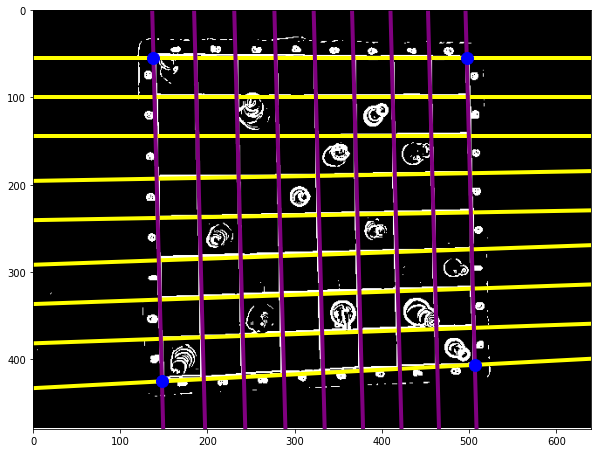

In [27]:
intersections = find_intersections(h_angles_4, h_dists_4, v_angles_4, v_dists_4)
corners = [intersections[0], intersections[-9], intersections[-1], intersections[8]]

plot_lines_hough(im_processed, h_angles_4, h_dists_4, line_color='yellow')
plot_lines_hough(im_processed, v_angles_4, v_dists_4, points=corners, line_color='purple')

In [28]:
def four_point_transform(im, points):
    '''
    Warps the chessboard to a new image so that the persepctive is inverted.

    Arguments:
        im the image to use
        points a list of four points that represents the corners in counter-clockwise.

    Returns:
        the transformed image
    '''
    src_points = np.float32(points)
    dst_points = np.float32([[0, 0], [0, BOARD_CUTOUT_SIZE[1]], [BOARD_CUTOUT_SIZE[0], BOARD_CUTOUT_SIZE[1]], [BOARD_CUTOUT_SIZE[0], 0]])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    
    return cv2.warpPerspective(im, M, BOARD_CUTOUT_SIZE)

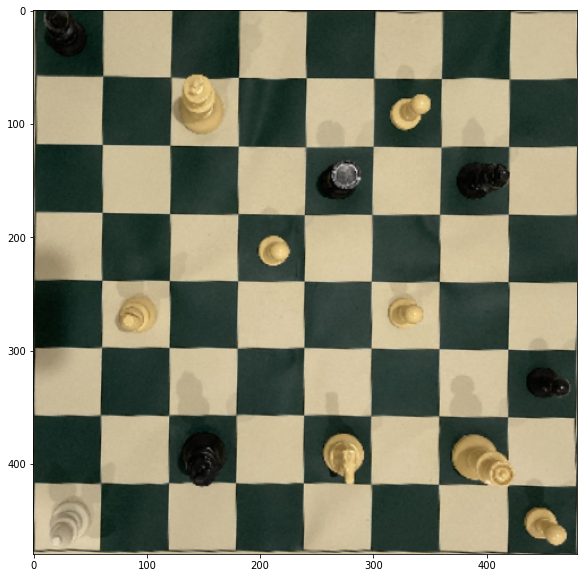

In [29]:
# color.gray2rgb(im_processed).astype('uint8')

im_cropped = four_point_transform(
    im_board, corners)
#im_cropped = color.rgb2gray(im_cropped)

plt.imshow(im_cropped)

In [48]:
TILE_BORDER_WIDTH = 3
OTSU_PADDING_MULTIPLIER = 1.1

def find_empty_squares(im):
    '''
    Find all the empty squares by counting the number of unique colors on each tile.

    Arguments:
        im an image with just the chessboard
    
    Returns:
        the input image with rectangles drawn on it
    '''
    h, w, _ = im.shape

    # Iterate tiles, and count unique colors
    # Creating a 8x8 filter that tries to see consistent patterns in its segmented portion
    tile_width = w // 8
    unique_colors_kernel = np.zeros((8, 8))
    tiles = []
    for x in np.arange(8):
        for y in np.arange(8):
            tile = im[
                y * tile_width: (y+1) * tile_width,
                x * tile_width: (x+1) * tile_width]
            tile = tile[TILE_BORDER_WIDTH:-TILE_BORDER_WIDTH, TILE_BORDER_WIDTH:-TILE_BORDER_WIDTH]
            tiles.append(tile)
            # if theres something out of the ordinary within the segmented tile mark it.
            unique_colors_kernel[y, x] = np.unique(tile.reshape(-1, tile.shape[-1]), axis=0).shape[0]

    # Mask empty squares using Otsu's method
    T = filters.threshold_otsu(unique_colors_kernel) * OTSU_PADDING_MULTIPLIER
    mask = unique_colors_kernel < T

    out = im.copy()

    # draw rectangles around 
    for x in np.arange(8):
        for y in np.arange(8):
            point1 = (x * tile_width + TILE_BORDER_WIDTH, y * tile_width + TILE_BORDER_WIDTH)
            point2 = ((x+1) * tile_width - TILE_BORDER_WIDTH, (y+1) * tile_width - TILE_BORDER_WIDTH)
            if mask[y, x]:
                # cv2.rectangle(out, point1, point2, (0, 0, 256), 2)
                pass
            else:
                cv2.rectangle(out, point1, point2, (0, 255, 0), 2)

    return out

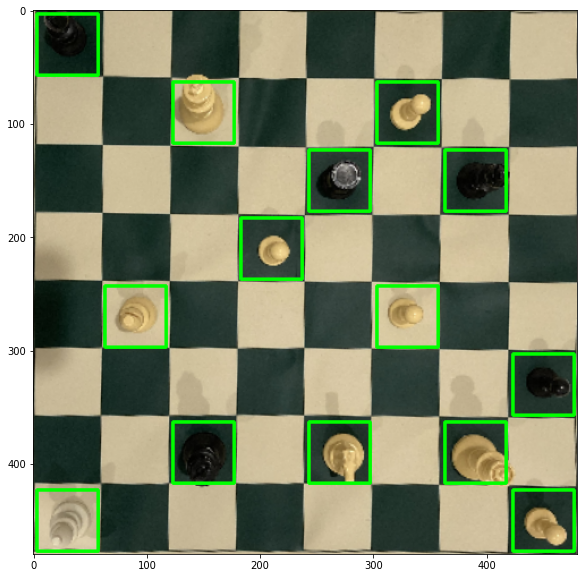

In [49]:
online_position = io.imread('chess_board_images/online_position.jpg')

plt.imshow(find_empty_squares(im_cropped))

In [32]:
from ImageProcessingF2021.video import run_video

In [50]:
def find_chess_board(im):
    EDGE_DETECTION_THRESHOLD = 0.05
    GAUSSIAN_BLUR_SIGMA = 0.7

    im_processed = process_chessboard_im(im)

    angles, dists = hough_lines(im_processed)

    normalized_angles = [normalize_angle(a) for a in angles]

    h_angles, h_dists = get_lines_range(normalized_angles, dists, [(-1, -6/8), (6/8, 1)])
    v_angles, v_dists = get_lines_range(normalized_angles, dists, [(-2/8, 2/8)])

    h_angles, h_dists = prune_lines_by_angle(h_angles, h_dists)
    v_angles, v_dists = prune_lines_by_angle(v_angles, v_dists)

    h, w = im_processed.shape

    h_points = find_intersections_2(h_angles, h_dists, [0], [w/2], [0])
    h_angles, h_dists, h_points = sort_lines_by_points(h_angles, h_dists, h_points, horizontal=True)

    v_points = find_intersections_2(v_angles, v_dists, [math.pi/2], [0], [h/2])
    v_angles, v_dists, v_points = sort_lines_by_points(v_angles, v_dists, v_points, horizontal=False)

    h_angles, h_dists = prune_nonchess_lines(h_angles, h_dists)
    v_angles, v_dists = prune_nonchess_lines(v_angles, v_dists)

    if len(h_angles) == 0:
        return im

    intersections = find_intersections(h_angles, h_dists, v_angles, v_dists)

    if len(intersections) != 81:
        return im

    corners = [intersections[0], intersections[-9], intersections[-1], intersections[8]]

    im_cropped = four_point_transform(im, corners)

    return find_empty_squares(im_cropped)
    
run_video(find_chess_board, camera_num=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xe0\x00\x00\x01\xe0\x08\x02\x00\x00\x00\xf2\xb6)…

array([[[173, 168, 156],
        [173, 168, 157],
        [171, 167, 156],
        ...,
        [161, 154, 144],
        [161, 154, 144],
        [161, 154, 143]],

       [[146, 144, 135],
        [146, 143, 135],
        [145, 141, 133],
        ...,
        [158, 154, 145],
        [159, 154, 145],
        [160, 154, 143]],

       [[114, 112, 103],
        [115, 112, 105],
        [116, 111, 105],
        ...,
        [153, 152, 144],
        [156, 153, 145],
        [159, 153, 144]],

       ...,

       [[161, 159, 147],
        [133, 138, 132],
        [ 80,  87,  84],
        ...,
        [111, 107,  97],
        [111, 106,  97],
        [109, 105,  94]],

       [[168, 164, 150],
        [153, 154, 144],
        [122, 125, 118],
        ...,
        [151, 146, 134],
        [150, 145, 132],
        [152, 148, 135]],

       [[175, 170, 154],
        [176, 172, 158],
        [174, 172, 160],
        ...,
        [162, 157, 143],
        [163, 157, 142],
        [164, 159, 143]]